In [1]:
import cv2
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [2]:
# Função para capturar uma foto da webcam
def capture_photo(filename='captured_face.jpg', quality=0.8):
    js_code = Javascript('''
        async function capturePhoto(quality) {
          const container = document.createElement('div');
          const captureButton = document.createElement('button');
          captureButton.textContent = 'Capture Face';
          container.appendChild(captureButton);

          const videoElement = document.createElement('video');
          videoElement.style.display = 'block';
          const mediaStream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(container);
          container.appendChild(videoElement);
          videoElement.srcObject = mediaStream;
          await videoElement.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          await new Promise((resolve) => captureButton.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = videoElement.videoWidth;
          canvas.height = videoElement.videoHeight;
          canvas.getContext('2d').drawImage(videoElement, 0, 0);
          mediaStream.getVideoTracks()[0].stop();
          container.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js_code)
    data_url = eval_js('capturePhoto({})'.format(quality))
    binary_data = b64decode(data_url.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary_data)

    return filename

In [7]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-02-10 20:36:55--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2025-02-10 20:36:55 (15.7 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-02-10 20:36:55--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [8]:
def load_face_detector():
    model_definition = '/content/deploy.prototxt'  # Atualize o caminho para onde o arquivo está localizado
    model_weights = '/content/res10_300x300_ssd_iter_140000.caffemodel'  # Atualize o caminho para onde o arquivo está localizado
    return cv2.dnn.readNetFromCaffe(model_definition, model_weights)

In [5]:
# Função principal para detectar e exibir rostos
def detect_faces(image_file):
    # Leitura da imagem capturada
    image = cv2.imread(image_file)
    image = imutils.resize(image, width=400)  # Ajuste do tamanho da imagem
    (h, w) = image.shape[:2]

    # Exibe a imagem para conferirmos
    cv2_imshow(image)

    # Carrega o modelo de detecção
    print("[INFO] Carregando modelo...")
    net = load_face_detector()

    # Pré-processamento da imagem para o modelo
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Passa a imagem pelo modelo para fazer as detecções
    print("[INFO] Realizando deteções...")
    net.setInput(blob)
    detections = net.forward()

    # Desenhando as caixas de detecção
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Ignora detecções com confiança abaixo de 50%
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            text = f"{confidence * 100:.2f}%"
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # Exibe a imagem final com as detecções
    cv2_imshow(image)

<IPython.core.display.Javascript object>

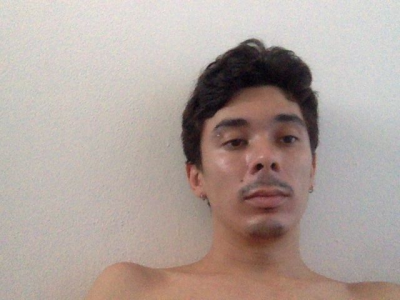

[INFO] Carregando modelo...
[INFO] Realizando deteções...


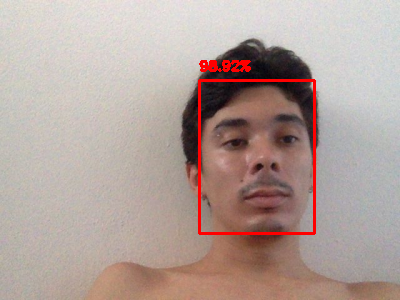

In [9]:
# Captura a foto da webcam e realiza a detecção
image_file = capture_photo()
detect_faces(image_file)